# Data pre-processing and visualisation

In [2]:
#checking if GPU is connected or not
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
#information of the connected device
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2247696731490406705, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11344216064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17801271067168416292
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [4]:
#connecting to the google drive and the files
from google.colab import drive
drive.mount('/content/drive')
train_file = '/content/drive/My Drive/Colab Notebooks/CA1/train.csv'
test_file = '/content/drive/My Drive/Colab Notebooks/CA1/test.csv'
sample_submission_file = '/content/drive/My Drive/Colab Notebooks/CA1/sample_submission.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Import and pre-processing of data.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#importing scikit-learn packages that we will be working with
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#ANN packages
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.models import Sequential
from keras.layers import Activation, Dense

In [6]:
#importing the dataset 

train_file = '/content/drive/My Drive/Colab Notebooks/CA1/train.csv'
test_file = '/content/drive/My Drive/Colab Notebooks/CA1/test.csv'
sample_submission_file = '/content/drive/My Drive/Colab Notebooks/CA1/sample_submission.csv'

sample_submission = pd.read_csv(sample_submission_file)
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

#dropping unnecessary column from train dataset and test dataset
train_data = train_data.drop(["Unnamed: 0"],axis=1)
X_test = test_data.drop(["Unnamed: 0"],axis=1)

X = train_data.drop('target', axis=1)
y = train_data.target

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   col_0   160000 non-null  float64
 1   col_1   160000 non-null  float64
 2   col_2   160000 non-null  float64
 3   col_3   160000 non-null  float64
 4   col_4   160000 non-null  float64
 5   col_5   160000 non-null  float64
 6   col_6   160000 non-null  float64
 7   col_7   160000 non-null  float64
 8   col_8   160000 non-null  float64
dtypes: float64(9)
memory usage: 11.0 MB


The pie plot shows how the suvived and not survived are distributed in the training data. Here, 57.104% didn't survive. 

([<matplotlib.patches.Wedge at 0x7f7bc6225d90>,
 [Text(-1.0727206408999876, -0.24345518393971421, 'Survived'),
  Text(1.0727206636939024, 0.24345508350435777, 'Didnt Survive')],
 [Text(-0.5851203495818114, -0.13279373669438954, '57.104'),
  Text(0.5851203620148557, 0.13279368191146784, '42.896')])

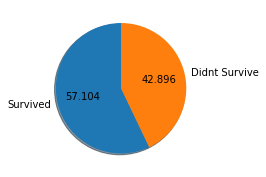

In [31]:
plt.figure(figsize=(3,3))
plt.pie(y.value_counts(),startangle=90,autopct='%.3f',labels=['Survived', 'Didnt Survive'],shadow=True)

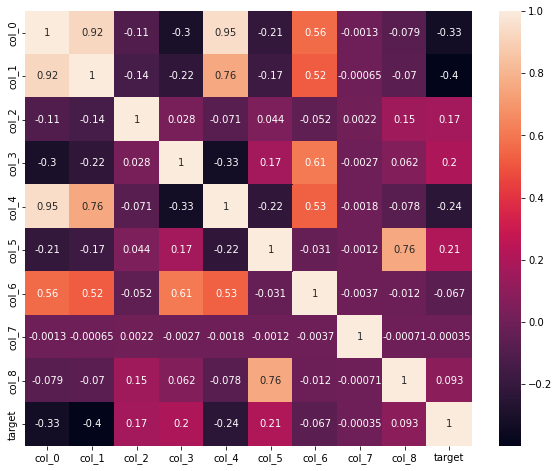

In [9]:
#Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(train_data.corr(),annot=True)

Comments, describe what do you see from the visualisations

Heat maps .Those that are highest in their value – relative to the other present numbers – will be given a “hot” color, while those that are lower in their value will be given a “cold” color. Col_0 is highly correlated with Col_4 and Col_1.So, change in Col_0 would cause change to another and so the model results fluctuate significantly. Col_1 is least correlated with the target.

#Preprocessing

In [10]:
#Checking for missing values
X.isna().sum()
X_test.isna().sum()

col_0    0
col_1    0
col_2    0
col_3    0
col_4    0
col_5    0
col_6    0
col_7    0
col_8    0
dtype: int64

In [11]:
#splitting the train data into train and test set
X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.30, random_state=123, stratify=y)

In [12]:
# Classification model based on algorithms from scikit-learn

#Logistic Regression

sc = StandardScaler()
model = LogisticRegression(random_state=123)
pipeline = make_pipeline(sc, model)
param_grid = [
              {'logisticregression__penalty': ['none']},
              {'logisticregression__penalty': ['l2'],'logisticregression__C': [0.001, 0.01, 0.1, 0.5, 1]},
              {'logisticregression__penalty': ['l2'],'logisticregression__C': [0.001, 0.01, 0.1, 0.5, 1]}]

grid = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

best_estimator = grid.best_estimator_

{'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}
0.7136160714285715


In [13]:
# initialise data of lists.
logR = {'Name':['Logistic Regression'],'Score':grid.best_score_}
# Creates pandas DataFrame.
Best_classi = pd.DataFrame(logR)
Best_classi

,Name,Score
0,Logistic Regression,0.713616


In [14]:
from sklearn.neighbors import KNeighborsClassifier
sc = StandardScaler()
model = KNeighborsClassifier()
pipeline = make_pipeline(sc, model)

param_grid = {
    'kneighborsclassifier__n_neighbors': [2,3,5,6,7,8,9,10],
}

grid = GridSearchCV(pipeline, param_grid, cv=10, n_jobs=-1, verbose=2, scoring='accuracy')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

best_estimator = grid.best_estimator_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.9min finished


{'kneighborsclassifier__n_neighbors': 9}
0.7860982142857144


In [15]:
# initialise data of lists.
knn = {'Name':'KNeighborsClassifier','Score':grid.best_score_}
# Add to the dataframe
Best_classi = Best_classi.append(knn,ignore_index=True)
Best_classi

,Name,Score
0,Logistic Regression,0.713616
1,KNeighborsClassifier,0.786098


KNeighbours Classifier implements the k-nearest neighbors vote.

In [16]:
#Random Forrest
sc = StandardScaler()
model = RandomForestClassifier(random_state=123)
pipeline = make_pipeline(sc, model)

param_grid = {
              'randomforestclassifier__max_depth': [10, 50],
              'randomforestclassifier__n_estimators': [50, 100]}


grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

best_estimator = grid.best_estimator_

{'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100}
0.8111428629322096


In [17]:
# initialise data of lists.
rf = {'Name':['Random Forrest'],'Score':grid.best_score_}
# Creates pandas DataFrame.
Best_en = pd.DataFrame(rf)
Best_en

,Name,Score
0,Random Forrest,0.811143


RandomForestClassifier is a supervised learning algorithm which is a collection of many decision trees. It utilizes ensemble technique, that combines many classifiers to a complex problem to provide a solution.

In [18]:
#GradientBoostingClassifier
sc = StandardScaler()
model = GradientBoostingClassifier(random_state=123)
pipeline = make_pipeline(sc, model)

param_grid = {
              'gradientboostingclassifier__max_depth': [1, 10, 50],
              'gradientboostingclassifier__n_estimators': [10, 50]}


grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=0, scoring='accuracy')

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

best_estimator = grid.best_estimator_

{'gradientboostingclassifier__max_depth': 10, 'gradientboostingclassifier__n_estimators': 50}
0.8109107019788903


In [19]:
# initialise data of lists.
gb = {'Name':'GradientBoostingClassifier','Score':grid.best_score_}
Best_en = Best_en.append(gb,ignore_index=True)
Best_en

,Name,Score
0,Random Forrest,0.811143
1,GradientBoostingClassifier,0.810911


In [20]:
print(classification_report(y_val, best_estimator.predict(X_val)))
print(confusion_matrix(y_val, best_estimator.predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84     27410
         1.0       0.79      0.78      0.78     20590

    accuracy                           0.81     48000
   macro avg       0.81      0.81      0.81     48000
weighted avg       0.81      0.81      0.81     48000

[[23037  4373]
 [ 4579 16011]]


We have got almost 83% prediction result.


*   23037 patients were predicted that they will not survive,the Prediction was CORRECT (True-Positive)
*   16011 patients were predicted that they will survive,the Prediction was CORRECT (True-Negative)
*   4373 patients were predicted that they will not survive but the Prediction was WRONG (False-Positive)
*   4579 patients were predicted that they will survive but the Prediction was WRONG (False-Negative)









# **ANN** - Artificial Neural Network

In [21]:
sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_val_std = sc.transform(X_val)
X_test_std = sc.transform(X_test)

In [23]:
#Define, compile or train model
from keras.layers import Dropout
model = Sequential()
model.add(Dense(units = 512, kernel_initializer = 'uniform', activation = 'relu', input_dim = 9))
model.add(Dropout(rate = 0.1))

model.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(1, activation='sigmoid'))

In [24]:
# compile the model
model.compile(loss='BinaryCrossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [25]:
#  fit the keras model on the dataset(training the model)
start = time.time()
model.fit(X_train_std, y_train.to_numpy(), epochs=120,  batch_size=60, validation_split=0.2, shuffle=True)
stop=time.time()
print('Training time:{0}'.format(stop-start))
model.summary()

Epoch 1/120
1494/1494 [==============================] - 12s 6ms/step - loss: 0.4954 - accuracy: 0.7702 - val_loss: 0.4531 - val_accuracy: 0.7966
Epoch 2/120
1494/1494 [==============================] - 8s 6ms/step - loss: 0.4651 - accuracy: 0.7864 - val_loss: 0.4405 - val_accuracy: 0.7995
Epoch 3/120
1494/1494 [==============================] - 8s 5ms/step - loss: 0.4582 - accuracy: 0.7898 - val_loss: 0.4470 - val_accuracy: 0.7946
Epoch 4/120
1494/1494 [==============================] - 8s 5ms/step - loss: 0.4556 - accuracy: 0.7897 - val_loss: 0.4417 - val_accuracy: 0.7976
Epoch 5/120
1494/1494 [==============================] - 8s 6ms/step - loss: 0.4533 - accuracy: 0.7921 - val_loss: 0.4407 - val_accuracy: 0.8009
Epoch 6/120
1494/1494 [==============================] - 8s 5ms/step - loss: 0.4530 - accuracy: 0.7908 - val_loss: 0.4340 - val_accuracy: 0.8017
Epoch 7/120
1494/1494 [==============================] - 8s 5ms/step - loss: 0.4522 - accuracy: 0.7911 - val_loss: 0.4401 - val_a

In [26]:
results = model.evaluate(X_val_std, y_val.to_numpy())

1500/1500 [==============================] - 4s 3ms/step - loss: 0.4263 - accuracy: 0.8063


The accuracy is quite good and the loss is also not so bad.

In [27]:
# Predicting the Test set results
predict = model.predict(X_test_std)
predict = np.where(predict < 0.5,0.0,1.0)

In [28]:
#saving the predited data in CSV format in Google Drive.
beatme_submission = sample_submission
beatme_submission['Survived'] = predict
beatme_submission.to_csv('/content/drive/My Drive/Colab Notebooks/CA1/beatme_submission_ANN.csv', index=False)
print("Your submission was sucessfully saved!")

Your submission was sucessfully saved!


# Results

In [30]:
# Code for your best classification model (scikit-learn). See Canvas assignment note "Modelling" point 1
# initialise data of lists.
Best_classi

,Name,Score
0,Logistic Regression,0.713616
1,KNeighborsClassifier,0.786098


In [29]:
# Code for your best ensemble model (scikit-learn). See Canvas assignment note "Modelling" point 1
Best_en

,Name,Score
0,Random Forrest,0.811143
1,GradientBoostingClassifier,0.810911
